### This is a demo for dem generation by using aster stereo images.
#### We use asp tool to perform dem generation. and we will compare the dem generation through: 
##### 1) running stereo with original images and 2) with mapprojected images (Auxiliary low-resolution dem data is required)



In [2]:
import os
os.chdir('..')
import numpy as np
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff
from utils.lay_stack import lay_stack
from utils.imgShow import imgShow
from utils.get_dem import get_dem


#### Parameters settings

In [3]:
output_res = 30  # m resolution for output DEM
map_res = 15     # m  resolution for orthorectified input stereo pair
utm_zone = '10'
tsrs_wgs84 = '+proj=longlat +datum=WGS84' # UTM projection 
tsrs_utm = '+proj=utm +zone=' + utm_zone + ' +ellps=WGS84 +datum=WGS84 +units=m +no_defs' # UTM projection 
# dir_raw_aster = 'data/aster_data/wkunlun-2020/aster_raw_L1A/AST_L1A_00303212020053451_20220315030514_20356'
dir_raw_aster = 'data/aster_data/demo/AST_L1A_00307312017190728_20200218153629_19952'  ## zone=10, epsg_code=32610
dir_out='data/aster_data/demo'



### **1. Running stereo with original images.**

### 1.1. Parse the l1a aster data

In [8]:
!aster2asp $dir_raw_aster -o $dir_out/run


	--> Setting number of processing threads to: 4
Writing: data/aster_data/demo/run-Band3N.xml
Writing: data/aster_data/demo/run-Band3B.xml
Writing: data/aster_data/demo/run-Band3N.tif
        -->: [*******************************************************] Complete!
Writing: data/aster_data/demo/run-Band3B.tif
        -->: [*******************************************************] Complete!


### 1.2. Generate point cloud data

In [9]:
!parallel_stereo -t aster --subpixel-mode 3 $dir_out/run-Band3N.tif \
                      $dir_out/run-Band3B.tif $dir_out/run-Band3N.xml \
                      $dir_out/run-Band3B.xml $dir_out/pc_out/run


Using tiles (before collar addition) of 2048 x 2048 pixels.
Using a collar (padding) for each tile of 0 pixels.

[ 2022-Mar-27 21:16:54 ] : Stage 0 --> PREPROCESSING 
	--> Setting number of processing threads to: 4
Stereo file ./stereo.default could not be found. Will use default settings and command line options only.
Writing log info to: data/aster_data/demo/pc_out/run-log-stereo_pprc-03-27-2116-13762.txt
Using session: aster.
Loading camera model: data/aster_data/demo/run-Band3N.tif data/aster_data/demo/run-Band3N.xml
Loading camera model: data/aster_data/demo/run-Band3B.tif data/aster_data/demo/run-Band3B.xml
Distance between camera centers in meters: 410534.
Using image files:  data/aster_data/demo/run-Band3N.tif, data/aster_data/demo/run-Band3B.tif
Using camera files: data/aster_data/demo/run-Band3N.xml, data/aster_data/demo/run-Band3B.xml
Computing statistics for left
Using downsample scale: 5
	    Writing stats file: data/aster_data/demo/pc_out/run-run-Band3N-stats.tif
	    lef

### 2.3. covert cloud point file to dem image

In [19]:
## 0.0002777(in degrees), 0.00013885 and 0.0000898 is about 31, 15 and 10 m/pixel
# !point2dem --tr 0.0002777 $dir_out/pc_out/run-PC.tif -o $dir_out/dem_out/run
# !point2dem --tr 30 --t_srs '{tsrs}' --errorimage $dir_out/pc_out/run-PC.tif -o $dir_out/dem_out/run
!point2dem --tr 30 --t_srs "$tsrs_utm" --errorimage $dir_out/pc_out/run-PC.tif -o $dir_out/dem_out/run


	--> Setting number of processing threads to: 4
Writing log info to: data/aster_data/demo/dem_out/run-log-point2dem-03-27-2149-16688.txt
Statistics: [********************************************************] Complete!
Bounding box and triangulation error range estimation: [*************] Complete!
QuadTree: [**********************************************************] Complete!
Automatic triangulation error cutoff is 92.1231 meters.
	-- Starting DEM rasterization --
	--> DEM spacing: 30 pt/px
	             or: 0.0333333 px/pt
Creating output file that is Vector2(2428,2369) px.
Writing: data/aster_data/demo/dem_out/run-DEM.tif
DEM: [***************************************************************] Complete!
Percentage of valid pixels = 0.71922
Writing: data/aster_data/demo/dem_out/run-IntersectionErr.tif
IntersectionErr: [***************************************************] Complete!


#### Reprojection (to wgs84) for the aster stereo image. 
#### !The aster image with wgs84 also provides extent for dem downloading.

In [24]:
# re-projected the l1a VNIR bands (15 m, bands of green, red, nir-B, nir-N)
!mapproject -t rpc --t_srs "$tsrs_wgs84" WGS84 $dir_out/run-Band3N.tif $dir_out/run-Band3N.xml $dir_out/VNIR-Band3N_wgs84.tif
!mapproject -t rpc --t_srs "$tsrs_wgs84" WGS84 $dir_out/run-Band3B.tif $dir_out/run-Band3B.xml $dir_out/VNIR-Band3B_wgs84.tif
!mapproject -t rpc --t_srs "$tsrs_wgs84" WGS84 $dir_raw_aster/*VNIR_Band1*.tif $dir_out/run-Band3N.xml $dir_out/VNIR-Band1_wgs84.tif
!mapproject -t rpc --t_srs "$tsrs_wgs84" WGS84 $dir_raw_aster/*VNIR_Band2*.tif $dir_out/run-Band3N.xml $dir_out/VNIR-Band2_wgs84.tif



mapproject_single --query-projection WGS84 data/aster_data/demo/run-Band3N.tif data/aster_data/demo/run-Band3N.xml data/aster_data/demo/VNIR-Band3N_wgs84.tif -t rpc --t_srs +proj=longlat +datum=WGS84
	--> Setting number of processing threads to: 4
Using session: rpc.
Loading camera model: data/aster_data/demo/run-Band3N.tif data/aster_data/demo/run-Band3N.xml
	--> Using flat datum "WGS84" as elevation model.
Output pixel size: 0.000170209
Projected space bounding box: (Origin: (237.643, 46.6959) width: 1.01751 height: 0.659899)
Image box: (Origin: (0, 0) width: 5979 height: 3878)
Output image size:
(width: 5979 height: 3878)
Query finished, exiting mapproject tool.

Output image size is 5979 by 3878 pixels.
Splitting into 2 by 1 tiles.
parallel --will-cite --workdir /Users/luo/Library/CloudStorage/OneDrive-Personal/GitHub/Glacier-in-RGI1305 -u --env PATH --env PYTHONPATH --env ISISROOT --env ISISDATA -a data/aster_data/demo/VNIR-Band3N_wgs84_tif_tiles/argumentList.txt -P 2 --colsep \t 

In [25]:
path_aster_wgs84 = dir_out + '/VNIR-Band3N_wgs84.tif'
aster_wgs84, aster_wgs84_info = readTiff(path_aster_wgs84); print('aster_wgs84:',aster_wgs84_info)
path_dem_aster = 'data/aster_data/demo/dem_out/run-DEM.tif'
dem_aster, dem_aster_info = readTiff(path_dem_aster); print('dem_aster:', dem_aster_info)


aster_wgs84: {'geoextent': (237.64256991588627, 238.66024696754175, 46.69578556579654, 47.35585440779687), 'geotrans': (237.64256991588627, 0.00017020857194438577, 0.0, 47.35585440779687, 0.0, -0.00017020857194438577), 'geosrs': '4326', 'row': 3878, 'col': 5979, 'bands': 1}
dem_aster: {'geoextent': (549735.0, 622575.0, 5173365.0, 5244435.0), 'geotrans': (549735.0, 30.0, 0.0, 5244435.0, 0.0, -30.0), 'geosrs': '32610', 'row': 2369, 'col': 2428, 'bands': 1}


In [26]:
### layer stacking for VNIR bands.
Band1 = dir_out + '/VNIR-Band1_wgs84.tif'
Band2 = dir_out + '/VNIR-Band2_wgs84.tif' 
Band3N = dir_out + '/VNIR-Band3N_wgs84.tif' 
path_laysta_wgs84 = dir_out + '/VNIR_LayStack_wgs84.tif'
lay_stack(path_imgs=[Band1, Band2, Band3N], path_out=path_laysta_wgs84)


Images layer stacking done.


In [58]:
### !!! occurs bias with the VNIR_LayStack_utm.tif that is stacked by VNIR_utm bands.
# path_laysta_utm = dir_out + '/VNIR_LayStack_utm.tif'
# !gdalwarp -s_srs EPSG:4326 -t_srs "$tsrs_utm" -r bilinear $path_laysta_wgs84 $path_laysta_utm



Creating output file that is 5242P x 4980L.
Processing data/aster_data/demo/VNIR_LayStack_wgs84.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


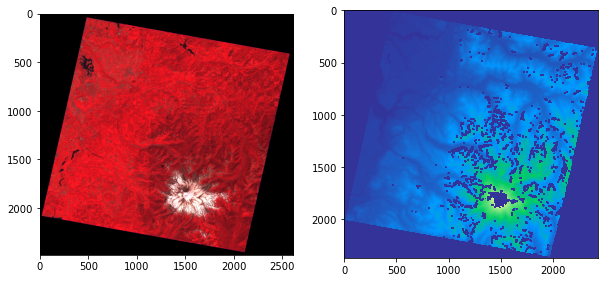

In [29]:
aster_vnir, aster_vnir_info = readTiff(path_laysta_utm)
aster_vnir[aster_vnir==-32768]=0
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); 
imgShow(aster_vnir, color_bands=[2,1,0], clip_percent=2)
plt.subplot(1,2,2); 
plt.imshow(dem_aster, vmin=0, vmax=8000, cmap='terrain')



### **2. Running stereo with mapprojected images.**

### 2.1. Get the srtm dem data of the region

In [45]:
aster_vnir, aster_vnir_info = readTiff(path_laysta_wgs84)
print(aster_vnir_info)
aoi_extent = list(aster_vnir_info['geoextent'])
if aoi_extent[0] > 180:
  aoi_extent[0] = aoi_extent[0] - 360
if aoi_extent[1] > 180:
  aoi_extent[1] = aoi_extent[1] - 360
print(aoi_extent)
path_srtm_wgs84 = 'data/aster_data/demo/srtm_dem_wgs84.tif'
get_dem('SRTMGL1_E', aoi_extent, '7f97d1b49489d7c0e346b085772aef3c', path_out=path_srtm_wgs84)



{'geoextent': (237.64256991588627, 238.66024696754175, 46.69578556579654, 47.35585440779687), 'geotrans': (237.64256991588627, 0.00017020857194438577, 0.0, 47.35585440779687, 0.0, -0.00017020857194438577), 'geosrs': '4326', 'row': 3878, 'col': 5979, 'bands': 3}
[-122.35743008411373, -121.33975303245825, 46.69578556579654, 47.35585440779687]
!!Output file has been existed.


##### Reprojection for the srtm dem data

In [46]:
path_srtm_wgs84 = 'data/aster_data/demo/srtm_dem_wgs84.tif'
path_srtm_utm = 'data/aster_data/demo/srtm_dem_utm.tif'
!gdalwarp -overwrite -s_srs EPSG:4326 -t_srs "$tsrs_utm" -tr 30 30 -r cubic -co COMPRESS=LZW -co TILED=YES $path_srtm_wgs84 $path_srtm_utm



Creating output file that is 2613P x 2482L.
Processing data/aster_data/demo/srtm_dem_wgs84.tif [1/1] : 0Using internal nodata values (e.g. -32768) for image data/aster_data/demo/srtm_dem_wgs84.tif.
Copying nodata values from source data/aster_data/demo/srtm_dem_wgs84.tif to destination data/aster_data/demo/srtm_dem_utm.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


{'geoextent': (548510.491134499, 626900.491134499, 5171599.458171177, 5246059.458171177), 'geotrans': (548510.491134499, 30.0, 0.0, 5246059.458171177, 0.0, -30.0), 'geosrs': '32610', 'row': 2482, 'col': 2613, 'bands': 1}


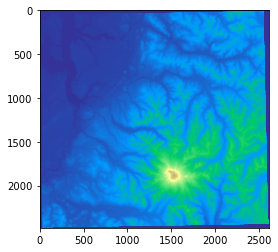

In [47]:
srtm_utm, srtm_utm_info = readTiff(path_srtm_utm)
print(srtm_utm_info)
plt.imshow(srtm_utm,vmin=0, vmax=7000, cmap='terrain')


In [48]:
# re-projected the l1a VNIR bands (15 m, bands of green, red, nir-B, nir-N)
!mapproject -t rpc --tr 15 --t_srs "$tsrs_utm" $path_srtm_utm $dir_out/run-Band3N.tif $dir_out/run-Band3N.xml $dir_out/VNIR-Band3N_utm.tif
!mapproject -t rpc --tr 15 --t_srs "$tsrs_utm" $path_srtm_utm $dir_out/run-Band3B.tif $dir_out/run-Band3B.xml $dir_out/VNIR-Band3B_utm.tif
!mapproject -t rpc --tr 15 --t_srs "$tsrs_utm" $path_srtm_utm $dir_raw_aster/*VNIR_Band1*.tif $dir_out/run-Band3N.xml $dir_out/VNIR-Band1_utm.tif
!mapproject -t rpc --tr 15 --t_srs "$tsrs_utm" $path_srtm_utm $dir_raw_aster/*VNIR_Band2*.tif $dir_out/run-Band3N.xml $dir_out/VNIR-Band2_utm.tif



mapproject_single --query-projection data/aster_data/demo/srtm_dem_utm.tif data/aster_data/demo/run-Band3N.tif data/aster_data/demo/run-Band3N.xml data/aster_data/demo/VNIR-Band3N_utm.tif -t rpc --tr 15 --t_srs +proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs
	--> Setting number of processing threads to: 4
Using session: rpc.
Loading camera model: data/aster_data/demo/run-Band3N.tif data/aster_data/demo/run-Band3N.xml
Output pixel size: 15
Projected space bounding box: (Origin: (549135, 5.17242e+06) width: 76500 height: 72615)
Image box: (Origin: (0, 0) width: 5101 height: 4842)
Output image size:
(width: 5101 height: 4842)
Query finished, exiting mapproject tool.

Output image size is 5101 by 4842 pixels.
Splitting into 1 by 1 tiles.
parallel --will-cite --workdir /Users/luo/Library/CloudStorage/OneDrive-Personal/GitHub/Glacier-in-RGI1305 -u --env PATH --env PYTHONPATH --env ISISROOT --env ISISDATA -a data/aster_data/demo/VNIR-Band3N_utm_tif_tiles/argumentList.txt -P 1 -

In [49]:
path_srtm_utm = 'data/aster_data/demo/srtm_dem_utm.tif'
!parallel_stereo -t astermaprpc --skip-rough-homography --subpixel-mode 3 \
                      $dir_out/VNIR-Band3N_utm.tif $dir_out/VNIR-Band3B_utm.tif \
                      $dir_out/run-Band3N.xml $dir_out/run-Band3B.xml \
                      $dir_out/pc_utm_out/run $path_srtm_utm


Using tiles (before collar addition) of 2048 x 2048 pixels.
Using a collar (padding) for each tile of 0 pixels.

[ 2022-Mar-27 22:45:43 ] : Stage 0 --> PREPROCESSING 
	--> Setting number of processing threads to: 4
Stereo file ./stereo.default could not be found. Will use default settings and command line options only.
Writing log info to: data/aster_data/demo/pc_utm_out/run-log-stereo_pprc-03-27-2245-19533.txt
Using session: astermaprpc.
Loading camera model: data/aster_data/demo/VNIR-Band3N_utm.tif data/aster_data/demo/run-Band3N.xml
Loading camera model: data/aster_data/demo/VNIR-Band3B_utm.tif data/aster_data/demo/run-Band3B.xml
Distance between camera centers in meters: 410534.
Using image files:  data/aster_data/demo/VNIR-Band3N_utm.tif, data/aster_data/demo/VNIR-Band3B_utm.tif
Using camera files: data/aster_data/demo/run-Band3N.xml, data/aster_data/demo/run-Band3B.xml
Using input DEM: data/aster_data/demo/srtm_dem_utm.tif
Computing statistics for left
Using downsample scale: 5
	

In [50]:
# !point2dem --tr 0.000277777777778 --errorimage $dir_out/pc_wgs84_out/run-PC.tif -o $dir_out/dem_wgs84_out/run
!point2dem --tr 30 --t_srs "$tsrs_utm" --errorimage $dir_out/pc_utm_out/run-PC.tif -o $dir_out/dem_utm_out/run



	--> Setting number of processing threads to: 4

Creating output directory: "data/aster_data/demo/dem_utm_out".
Writing log info to: data/aster_data/demo/dem_utm_out/run-log-point2dem-03-27-2300-21551.txt
Statistics: [********************************************************] Complete!
Bounding box and triangulation error range estimation: [*************] Complete!
QuadTree: [**********************************************************] Complete!
Automatic triangulation error cutoff is 91.627 meters.
	-- Starting DEM rasterization --
	--> DEM spacing: 30 pt/px
	             or: 0.0333333 px/pt
Creating output file that is Vector2(2432,2365) px.
Writing: data/aster_data/demo/dem_utm_out/run-DEM.tif
DEM: [***************************************************************] Complete!
Percentage of valid pixels = 0.723101
Writing: data/aster_data/demo/dem_utm_out/run-IntersectionErr.tif
IntersectionErr: [***************************************************] Complete!


In [51]:
### layer stacking for VNIR bands.
Band1 = dir_out + '/VNIR-Band1_utm.tif'
Band2 = dir_out + '/VNIR-Band2_utm.tif' 
Band3N = dir_out + '/VNIR-Band3N_utm.tif' 
path_laystack = dir_out + '/VNIR_LayStack_utm.tif'
lay_stack(path_imgs=[Band1, Band2, Band3N], path_out=path_laystack)


Images layer stacking done.


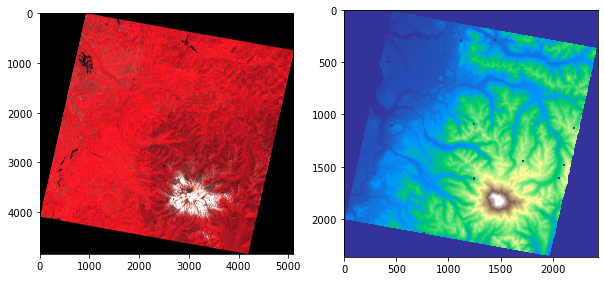

In [62]:
path_laysta_utm = dir_out + '/VNIR_LayStack_utm.tif'
path_dem_aster_utm = dir_out + '/dem_utm_out/run-DEM.tif'
dem_aster_utm, dem_aster_utm_info = readTiff(path_dem_aster_utm)
aster_vnir, aster_vnir_info = readTiff(path_laysta_utm)
aster_vnir[aster_vnir==-32768]=0
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); 
imgShow(aster_vnir, color_bands=[2,1,0], clip_percent=5)
plt.subplot(1,2,2); 
plt.imshow(dem_aster_utm, vmin=0, vmax=4000, cmap='terrain')


In [63]:
path_dems = dir_out + '/dems_utm.tif'
lay_stack(path_imgs=[path_srtm_utm, path_dem_aster_utm], path_out=path_dems)
dems_utm, dems_utm_info = readTiff(path_dems)
dems_dif = dems_utm[:,:,0]-dems_utm[:,:,1]


Images layer stacking done.


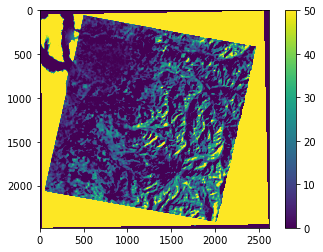

In [64]:
plt.imshow(dems_dif, vmin=0, vmax=50)
plt.colorbar()
